# Stable Voting

Implementation of Simple Stable Voting and Stable Voting from the paper [Stable Voting](https://arxiv.org/abs/2108.00542) by W. Holliday and E. Pacuit.  

In [1]:
# import the Profile class
from pref_voting.profiles import *
from pref_voting.voting_method import *
# import the voting methods
from pref_voting.voting_methods import *

from pref_voting.generate_profiles import *
import math
import pandas as pd
from itertools import product, combinations

from functools import partial
from multiprocess import Pool, cpu_count
import pickle
import timeit


## Simple Stable Voting 

Simple Stable Voting selects a winner as follows:

1. If only one candidate $a$ appears on all ballots, then $a$ wins.
2. Otherwise list all head-to-head matches of the form $a$ vs. $b$ in order from the largest to smallest margin of $a$ vs. $b$. Find the first match $a$ vs. $b$ in the list such that $a$ wins according to Simple Stable Voting *after $b$ is removed from all ballots*; this $a$ is the winner for the original set of ballots.  

Note that if there are two matches $a$ vs. $b$ and $a'$ vs. $b'$ with the same margins such that $a$ wins after $b$ is removed from the ballots, and $a'$ wins after $b'$ is removed from the ballots, then $a$ and $a'$ are tied Simple Stable Voting winners for the original set of ballots.


In [2]:
# This code is available in pref_voting.margin_methods.py but is included here for reference. 

def _simple_stable_voting(edata, curr_cands = None, mem_sv_winners = {}, strength_function = None): 

    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else edata.candidates 
    strength_function = edata.margin if strength_function is None else strength_function  
    
    sv_winners = list()

    matches = [(a, b) for a in curr_cands for b in curr_cands if a != b]
    strengths = list(set([strength_function(a, b) for a,b in matches]))
    
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for s in sorted(strengths, reverse=True):
        for a, b in [ab_match for ab_match in matches 
                     if strength_function(ab_match[0], ab_match[1]) == s]:
            if a not in sv_winners: 
                cands_minus_b = sorted([c for c in curr_cands if c!= b])
                if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                    ws, mem_sv_winners = _simple_stable_voting(edata, 
                                                               curr_cands = [c for c in curr_cands if c != b],
                                                               mem_sv_winners = mem_sv_winners,
                                                               strength_function = strength_function)
                    mem_sv_winners[tuple(cands_minus_b)] = ws
                else: 
                    ws = mem_sv_winners[tuple(cands_minus_b)]
                if a in ws:
                    sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners
        
@vm(name = "Simple Stable Voting")
def simple_stable_voting(edata, curr_cands = None, strength_function = None): 
    return _simple_stable_voting(edata, curr_cands = curr_cands, mem_sv_winners = {}, strength_function = strength_function)[0]



## Stable Voting

Stable Voting is analogously to Simple Stable Voting:

1. If there is only one undefeated candidate  $a$, then $a$ wins.
2. Otherwise list all head-to-head matches of the form $a$ vs. $b$ in order from the largest to smallest margin of $a$ vs. $b$, where $a$ is undefeated. Find the first match $a$ vs. $b$ in the list such that $a$ wins according to  Stable Voting *after $b$ is removed from all ballots*; this $a$ is the winner for the original set of ballots.  

We say that $b$ *does not defeat* $a$ if we can make a list of candidates starting with $a$ and ending with $b$ such that the margin of each candidate vs. the next candidate in the list is at least the margin of $b$ vs. $a$; if there is no such list, then $b$ defeats $a$; and $a$ is undefeated if there is no $b$ that defeats $a$ (this notion of defeat is defended at length in [Axioms for Defeat in Democratic Elections](https://arxiv.org/abs/2008.08451)). 


In [3]:
def find_undefeated_candidates(edata, curr_cands = None):   
    """
    A path from candidate a to candidate b is a list of candidates starting with a and ending with b 
    such that each candidate in the list has a nonzero margin vs. the next candidate in the list. 
    The strength of a path is the minimum margin between consecutive candidates in the path 
    The strength of the pair of candidates (a,b) is strength of the strongest path from a to b.   
    We find these strengths using the Floyd-Warshall Algorithm.   
    
    A candidate c is undefeated if for all candidates d that are majority preferred to c, 
    the strength of the strongest path from c to d is at least the margin of d over c. 
    
    Note that this is an implementation of the Split Cycle voting method. 
    """
    curr_cands = curr_cands if curr_cands is not None else edata.candidates
    mg = [[-np.inf for _ in curr_cands] for _ in curr_cands]
    for c1_idx,c1 in enumerate(curr_cands):
        for c2_idx,c2 in enumerate(curr_cands):
            if edata.margin(c1,c2) > 0:
                mg[c1_idx][c2_idx] = edata.margin(c1, c2)   

    # initial strength to mg
    strength = list(map(lambda i : list(map(lambda j : j , i)) , mg))
    
    for i_idx, i in enumerate(curr_cands):         
        for j_idx, j in enumerate(curr_cands): 
            if i != j:
                for k_idx, k in enumerate(curr_cands): 
                    if i!= k and j != k:
                        strength[j_idx][k_idx] = max(strength[j_idx][k_idx], min(strength[j_idx][i_idx], strength[i_idx][k_idx]))
    undefeated = {i:True for i in curr_cands}
    for i_idx, i in enumerate(curr_cands): 
        for j_idx,j in enumerate(curr_cands):
            if i != j:
                if mg[j_idx][i_idx] > strength[i_idx][j_idx]: # the main difference with Beat Path
                    undefeated[i] = False
    return sorted([c for c in curr_cands if undefeated[c]])


    
def _stable_voting(edata, curr_cands = None, mem_sv_winners = {}, strength_function = None): 

    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else edata.candidates
    strength_function = edata.margin if strength_function is None else strength_function  

    sv_winners = list()
    
    undefeated_candidates = find_undefeated_candidates(edata, curr_cands = curr_cands)
    matches = [(a, b) for a in curr_cands for b in curr_cands if a != b if a in undefeated_candidates]
    strengths = list(set([strength_function(a, b) for a,b in matches]))
        
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for s in sorted(strengths, reverse=True):
        for a, b in [ab_match for ab_match in matches 
                     if strength_function(ab_match[0], ab_match[1])  == s]:
            if a not in sv_winners: 
                cands_minus_b = sorted([c for c in curr_cands if c!= b])
                if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                    ws, mem_sv_winners = _stable_voting(edata, curr_cands = [c for c in curr_cands if c != b], mem_sv_winners = mem_sv_winners, strength_function = strength_function)
                    mem_sv_winners[tuple(cands_minus_b)] = ws
                else: 
                    ws = mem_sv_winners[tuple(cands_minus_b)]
                if a in ws:
                    sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners
        
@vm(name = "Stable Voting")
def stable_voting(edata, curr_cands = None, strength_function = None): 
    return _stable_voting(edata, curr_cands = curr_cands, mem_sv_winners = {}, strength_function = strength_function)[0]




## Stable Voting

The following examples (not included in the paper) illustrate (simple) stable voting.  For the examples in the paper see the notebook StableVotingExamples.ipynb. 

### Example A

The following is an example with a Condorcet winner ($B$) where the Instant Runoff winner ($A$) and the Plurality winners ($A$ and $C$) are different than the SV winner ($B$). 

+---+---+---+
| 2 | 1 | 2 |
+---+---+---+
| A | B | C |
| B | A | B |
| C | C | A |
+---+---+---+


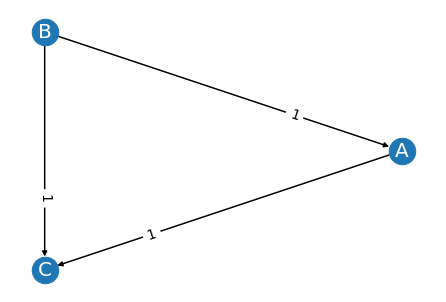

Instant Runoff winner is {A}
Plurality winners are {A, C}
Stable Voting winner is {B}
Simple Stable Voting winner is {B}
Condorcet winner is {B}


In [4]:
A = 0
B = 1 
C = 2

cmap = {A: "A", B: "B", C: "C" }
prof = Profile(
    [
        (A, B, C),
        (B, A, C), 
        (C, B, A)
    ], 
    rcounts = [2, 1, 2], 
    cmap=cmap
)

prof.display()

prof.display_margin_graph()
instant_runoff.display(prof)
plurality.display(prof)
stable_voting.display(prof)
simple_stable_voting.display(prof)
condorcet.display(prof)


### Example B

The following is an example without a Condorcet winner where the Instant Runoff winner ($D$) and the Plurality winners ($C$ and $D$),  and the Beat Path and Ranked Pairs winners ($B$, $C$ and $D$) are all different than the SV winner ($B$). 

+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| C | D | D | B |
| B | A | B | D |
| A | C | A | A |
| D | B | C | C |
+---+---+---+---+


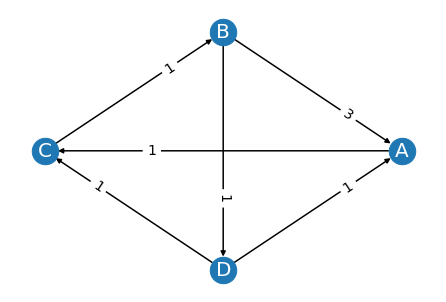

Instant Runoff winner is {D}
Plurality winners are {C, D}
Stable Voting winner is {B}
Simple Stable Voting winner is {B}
Beat Path winners are {B, C, D}
Ranked Pairs winners are {B, C, D}


In [5]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile(
    [
        (C, B, A, D),
        (D, A, C, B), 
        (D, B, A, C),
        (B, D, A, C)
], 
    rcounts = [2, 1, 1, 1], 
    cmap=cmap
)


prof.display()

prof.display_margin_graph()

instant_runoff.display(prof)
plurality.display(prof)
stable_voting.display(prof)
simple_stable_voting.display(prof)
beat_path_faster.display(prof)
ranked_pairs.display(prof)

### Example C

A different profile generating the same margin graph as in Example 2 above. This is an example without a Condorcet winner where the Instant Runoff winner ($C$), the Plurality winners ($B$ and $C$), and the Beat Path and Ranked Pairs winners ($B$, $C$ and $D$) are all different than the SV winner ($B$).

+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| A | B | C | C | B |
| D | D | B | D | A |
| C | A | D | B | D |
| B | C | A | A | C |
+---+---+---+---+---+


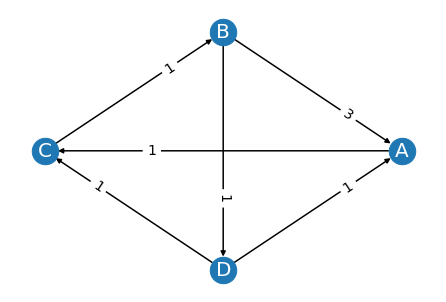

Instant Runoff winner is {C}
Plurality winners are {B, C}
Stable Voting winner is {B}
Simple Stable Voting winner is {B}
Beat Path winners are {B, C, D}
Ranked Pairs winners are {B, C, D}


In [6]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile(
    [
        (A, D, C, B),
        (B, D, A, C),
        (C, B, D, A),
        (C, D, B, A), 
        (B, A, D, C)
],
    rcounts = [1, 1, 1, 1, 1], 
    cmap=cmap
)

prof.display()

prof.display_margin_graph()

 
instant_runoff.display(prof)
plurality.display(prof)
stable_voting.display(prof)
simple_stable_voting.display(prof)
beat_path_faster.display(prof)
ranked_pairs.display(prof)



### Example D

An example in which the Ranked Pairs winners ($D$) is different than the Beat Path winners ($A$ and $D$), and both differ from the Stable Voting winner ($A$).

+---+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+
| D | A | B | A | D | A | C | C |
| A | C | D | B | A | D | B | A |
| C | B | A | D | B | C | D | B |
| B | D | C | C | C | B | A | D |
+---+---+---+---+---+---+---+---+


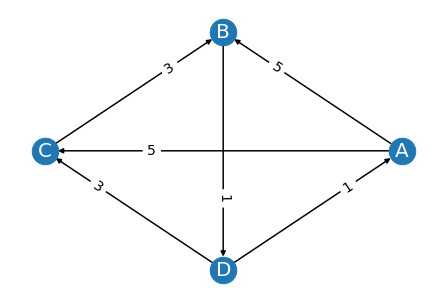

Instant Runoff winner is {D}
Plurality winners are {A, D}
Stable Voting winner is {A}
Simple Stable Voting winner is {A}
Beat Path winners are {A, D}
Ranked Pairs winner is {D}


In [7]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile(
    [
        (D, A, C, B),
        (A, C, B, D), 
        (B, D, A, C),
        (A, B, D, C), 
        (D, A, B, C), 
        (A, D, C, B), 
        (C, B, D, A), 
        (C, A, B, D)
],
    rcounts = [2, 1, 1, 1, 1, 1, 1, 1], 
    cmap=cmap
)

prof.display()

prof.display_margin_graph()

 
instant_runoff.display(prof)
plurality.display(prof)
stable_voting.display(prof)
simple_stable_voting.display(prof)
beat_path_faster.display(prof)
ranked_pairs.display(prof)

